In [137]:
import sys
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install seaborn
import numpy as np
import pandas
import seaborn as sns
import warnings
from ipywidgets import FloatProgress
from IPython.display import display, Markdown, Latex

In [2]:
debug_rounds = False
debug_matches = False

In [150]:
def d20():
    return np.random.randint(1,21)

def do_rounds_and_update(a,b,rounds,df):
    wins = do_match(a,b,rounds)
    a_wins = wins[0]
    b_wins = wins[1]
    a_id = a[0]
    b_id = b[0]
    df.at[a_id,'total_wins'] = df.at[a_id,'total_wins'] + a_wins
    df.at[b_id,'total_wins'] = df.at[b_id,'total_wins'] + b_wins
    if a_wins > b_wins:
        df.at[a_id,'pair_wins'] = df.at[a_id,'pair_wins'] + 1
    else:
        df.at[b_id,'pair_wins'] = df.at[b_id,'pair_wins'] + 1
    return df

def do_match(a,b,rounds):
    a_wins = 0
    b_wins = 0
    for _ in np.arange(rounds):
        wins = do_round(a,b)
        a_wins = a_wins + wins[0]
        b_wins = b_wins + wins[1]
    if debug_matches:
        print ("After %d rounds %s won %d times and %s won %d times" % (rounds,a.name,a_wins,b.name,b_wins))
    return [a_wins,b_wins]

def do_round( a, b ):
    a_init = d20() + a.init
    if debug_rounds:
        print("%s rolled %d init" % (a.name,a_init))
    b_init = d20() + b.init
    if debug_rounds:
        print("%s rolled %d init" % (b.name,b_init))
    if (a_init >= b_init):
        first = a.copy()
        second = b.copy()
        in_order = True
    else:
        first = b.copy()
        second = a.copy()
        in_order = False
    round = 0
    while (first.hp > 0 and second.hp > 0):
        if debug_rounds:
            print("    Round %d: %s hp is %d and %s hp is %d" % (round+1, first.name,first.hp,second.name,second.hp))
        round = round + 1
        first,second = do_attack(first,second)
        if (second.hp <= 0):
            if debug_rounds:
                print("%s is dead" % second.name)
            if in_order:
                return [1,0] #a went first and won
            else:
                return [0,1] #b went first and won
        else:
            second,first = do_attack(second,first)
            if (first.hp <= 0):
                if debug_rounds:
                    print("%s is dead" % first.name)
                if in_order:
                    return [0,1] #b went second and won
                else:
                    return [1,0] #a went second and won
    """Something went wrong here, nobody wins"""
    return [0,0]
    
def do_attack( attacker, target ):
    if debug_rounds:
        print ("        %s makes %d attacks against %s" % (attacker.name, attacker.att_num, target.name))
    for _ in np.arange(attacker.att_num):
        attack = d20() + attacker.hit_mod
        if (attack >= target.ac):
            target.hp = target.hp - attacker.dam_avg
            if debug_rounds:
                print("            %s hits %s for %d damage" % (attacker.name, target.name, attacker.dam_avg ))
        else:
            if debug_rounds:
                print("            %s misses %s" % (attacker.name, target.name))
    return [attacker, target]

def run_matches(creatures,rounds,name="creatures"):
    rows = creatures.shape[0]
    creatures['pair_wins'] = np.zeros(rows)
    creatures['total_wins'] = np.zeros(rows)

    matches = (rows**2+rows)/2

    f = FloatProgress(min=0, max=matches, description="Contest: ")
    display(f)

    print("Performing %d matches of %d rounds each" % (matches,rounds))
    for i in np.arange(rows):
        a = creatures.take([i]).to_records()[0]
        for j in np.arange(i+1,rows):
            b = creatures.take([j]).to_records()[0]
            creatures = do_rounds_and_update(a,b,rounds,creatures)
            f.value = f.value + 1
    
    filename = "%s_%02d.csv" % (name,rounds)
    creatures.to_csv(filename)

def gen_init(amount):
    """Generate initiative modifiers in range -5,5 with normal distribution"""
    s = np.round(np.random.normal(0, 1.66, amount),2)
    p = pandas.DataFrame(data=s)
    p = p[p[0].between(-5, 5, inclusive=True)]
    return p

def gen_ac(amount):
    return np.random.randint(13,20,amount)

def gen_hp(amount):
    return np.random.randint(10,810,amount)

def gen_att_num(amount):
    return np.random.randint(1,6,amount)

def gen_hit_mod(amount):
    return np.random.randint(3,15,amount)

def gen_dam_avg(amount):
    return np.random.randint(2,62,amount)

def create_randoms(size):
    """name,cr,ac,hp,init,att_num,hit_mod,dam_avg"""
    randoms = pandas.DataFrame()
    randoms['name'] = np.repeat([''],size)
    randoms['cr'] = np.zeros(size)
    randoms['ac'] = gen_ac(size)
    randoms['hp'] = gen_hp(size)
    randoms['init'] = gen_init(size)
    randoms['att_num'] = gen_att_num(size)
    randoms['hit_mod'] = gen_hit_mod(size)
    randoms['dam_avg'] = gen_dam_avg(size)
    return randoms

def plot_correl(file,col,logx=False,order=1):
    df = pandas.read_csv(file)
    return plot_correl_df(df,col,logx,order)

def plot_correl_df(df,col,logx=False,order=1):
    rows = df.shape[0]
    df['percent_wins'] = df['pair_wins'] / (rows-1)
    max_col = df.loc[df[col].idxmax()][col]
    df['percent_' + col] = df[col] / max_col
    df = df.sort_values(['percent_wins'],ascending=False)
    warnings.filterwarnings('ignore')
    r = np.corrcoef(df['percent_'+col],df['percent_wins'])[0][1]
    display(Markdown('### Correlation between %s and wins' % col))
    if np.absolute(r) < 0.3:
        randoms.plot.scatter(col,'pair_wins')
    else:
        sns.regplot(df['percent_'+col],df['percent_wins'],logx=logx,order=order)
    display(Markdown("r=%2f" % r))

In [8]:
creatures = pandas.read_csv('creatures.csv')
run_matches(creatures,100)

FloatProgress(value=0.0, description='Contest: ', max=52975.0)

Performing 52975 matches of 100 rounds each


### Correlation between hp and wins

r=0.739758

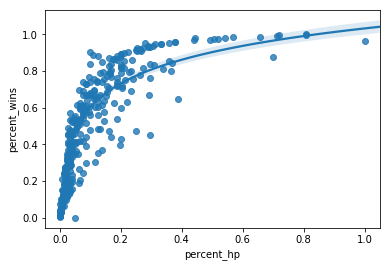

In [151]:
plot_correl('creatures_100.csv','hp',logx=True)

r=0.824020


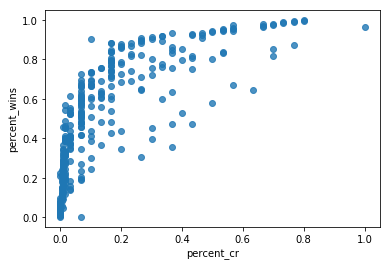

In [122]:
plot_correl('creatures_100.csv','cr',logx=True)

In [14]:
creatures = pandas.read_csv('creatures.csv')
creatures_avg = creatures.groupby('cr').mean().apply(np.round).astype(int).reset_index()
creatures_avg['name'] = creatures_avg['cr']
run_matches(creatures_avg,100,'creatures_avg')

FloatProgress(value=0.0, description='Contest: ', max=406.0)

Performing 406 matches of 100 rounds each


r=0.875335


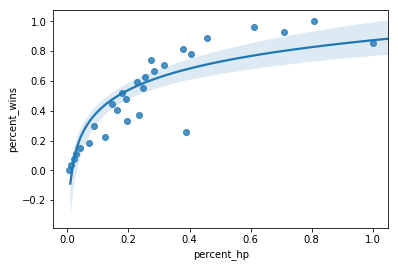

In [64]:
plot_correl('creatures_avg_100.csv','hp',logx=True)

r=0.873089


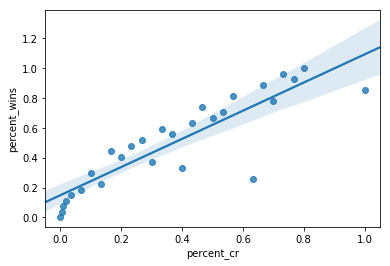

In [95]:
plot_correl('creatures_avg_100.csv','cr')

In [18]:
generics = pandas.read_csv('generics.csv')
run_matches(generics,100,'generics')

FloatProgress(value=0.0, description='Contest: ', max=561.0)

Performing 561 matches of 100 rounds each


r=0.995347


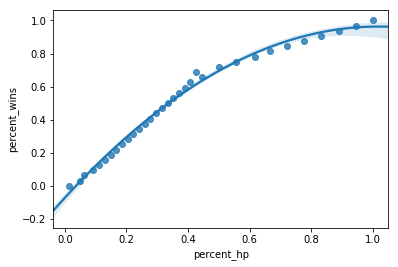

In [71]:
plot_correl('generics_100.csv','hp',order=2)

r=0.962000


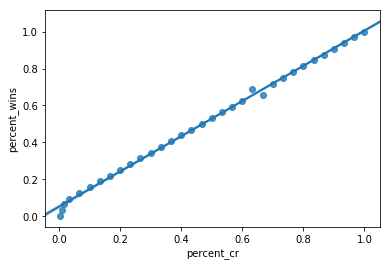

In [93]:
plot_correl('generics_100.csv','cr')

In [68]:
randoms = create_randoms(33)
run_matches(randoms,100,'randoms')

FloatProgress(value=0.0, description='Contest: ', max=561.0)

Performing 561 matches of 100 rounds each


r=0.486413


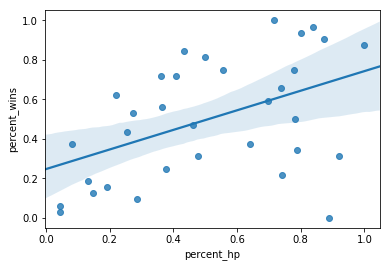

In [76]:
plot_correl('randoms_100.csv','hp')

r=-0.066177


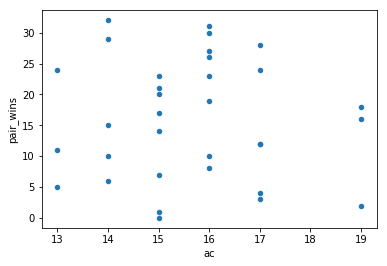

In [81]:
plot_correl('randoms_100.csv','ac')

r=0.022501


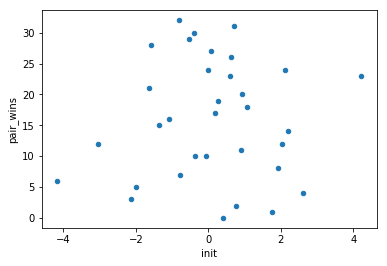

In [82]:
plot_correl('randoms_100.csv','init')

r=0.125077


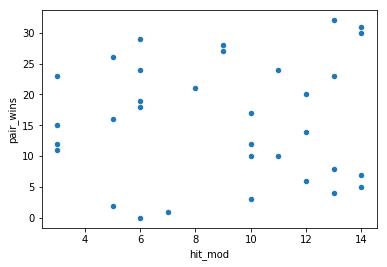

In [83]:
plot_correl('randoms_100.csv','hit_mod')

r=0.641841


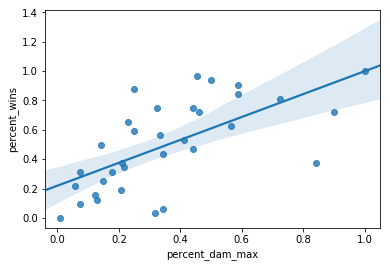

In [86]:
randoms = pandas.read_csv('randoms_100.csv')
randoms['dam_max'] = randoms['dam_avg'] * randoms['att_num']
plot_correl_df(randoms,'dam_max')

In [87]:
fighters = pandas.read_csv('fighters.csv')
run_matches(fighters,100,'fighters')

FloatProgress(value=0.0, description='Contest: ', max=210.0)

Performing 210 matches of 100 rounds each


r=0.994432


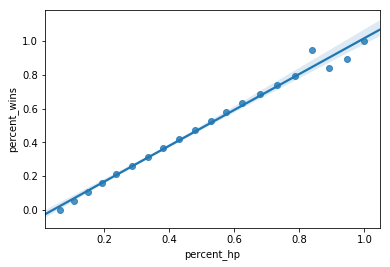

In [134]:
plot_correl('fighters_100.csv','hp')

r=0.967958


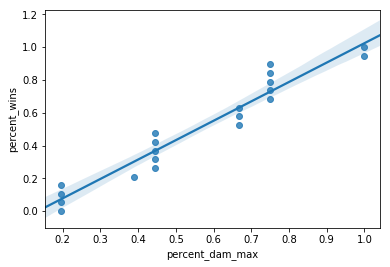

In [135]:
fighters = pandas.read_csv('fighters_100.csv')
fighters['dam_max'] = fighters['dam_avg'] * fighters['att_num']
plot_correl_df(fighters,'dam_max')

In [136]:
fighters = pandas.read_csv('fighters.csv')
generics = pandas.read_csv('generics.csv')
mixed = generics.append(fighters)
run_matches(mixed,100,'mixed')

FloatProgress(value=0.0, description='Contest: ', max=1431.0)

Performing 1431 matches of 100 rounds each


### Correlation between hp and wins

r=0.460919

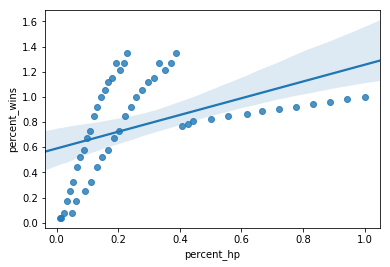

In [154]:
plot_correl('mixed_100.csv','hp')

### Correlation between dam_max and wins

r=0.389937

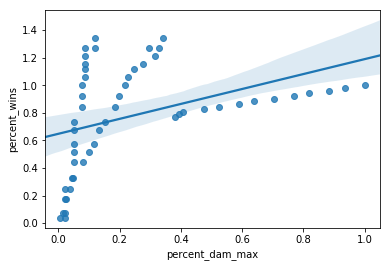

In [155]:
mixed = pandas.read_csv('mixed_100.csv')
mixed['dam_max'] = mixed['dam_avg'] * mixed['att_num']
plot_correl_df(mixed,'dam_max')

In [156]:
mixed.sort_values(['percent_wins'],ascending=False)

,Unnamed: 0,name,cr,ac,hp,init,att_num,hit_mod,dam_avg,pair_wins,total_wins,dam_max,percent_wins,percent_dam_max
52,19,Fighter 20,5.000,21,186,2,4,10,9,70.0,7024.0,36,1.346154,0.118033
19,19,CR 17,17.000,19,315,0,4,10,26,70.0,7024.0,104,1.346154,0.340984
51,18,Fighter 19,4.750,21,176,2,3,10,9,66.0,6550.0,27,1.269231,0.088525
49,16,Fighter 17,4.250,21,156,2,4,10,9,66.0,6574.0,36,1.269231,0.118033
18,18,CR 16,16.000,18,300,0,4,9,25,66.0,6550.0,100,1.269231,0.327869
16,16,CR 14,14.000,18,270,0,3,8,30,66.0,6574.0,90,1.269231,0.295082
50,17,Fighter 18,4.500,21,166,2,3,10,9,63.0,6374.0,27,1.211538,0.088525
17,17,CR 15,15.000,18,285,0,3,8,32,63.0,6374.0,96,1.211538,0.314754
48,15,Fighter 16,4.000,21,146,2,3,9,9,60.0,6041.0,27,1.153846,0.088525
15,15,CR 13,13.000,18,255,0,3,8,28,60.0,6041.0,84,1.153846,0.275410
